In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, chi2
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EmpiricalCovariance
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("C:/Users/smdce/Documents/creditcard.csv")

In [3]:
data = data.dropna()  
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['Class']))
y_true = data['Class'].values

In [4]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [5]:
z_scores = np.abs(zscore(scaled_data))
threshold = 3  # Set threshold
z_score_anomalies = (z_scores > threshold).any(axis=1).astype(int)
z_score_results = evaluate_model(y_true, z_score_anomalies)
print("Z-Score Results: Accuracy={}, Precision={}, Recall={}, F1 Score={}".format(*z_score_results))

Z-Score Results: Accuracy=0.868612779882517, Precision=0.01174106198434525, Recall=0.9024390243902439, F1 Score=0.023180536702516446


In [6]:
cov_model = EmpiricalCovariance().fit(scaled_data)
mahalanobis_dist = cov_model.mahalanobis(scaled_data)
chi2_threshold = chi2.ppf((1 - 0.01), scaled_data.shape[1])  # 99% threshold
mahalanobis_anomalies = (mahalanobis_dist > chi2_threshold).astype(int)
mahalanobis_results = evaluate_model(y_true, mahalanobis_anomalies)
print("Mahalanobis Results: Accuracy={}, Precision={}, Recall={}, F1 Score={}".format(*mahalanobis_results))

Mahalanobis Results: Accuracy=0.9382669667529239, Precision=0.024167501948992094, Recall=0.8821138211382114, F1 Score=0.04704607046070461


In [7]:
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_predictions = lof_model.fit_predict(scaled_data)
lof_anomalies = (lof_predictions == -1).astype(int)
lof_results = evaluate_model(y_true, lof_anomalies)
print("LOF Results: Accuracy={}, Precision={}, Recall={}, F1 Score={}".format(*lof_results))

LOF Results: Accuracy=0.9883464942926262, Precision=0.003861003861003861, Recall=0.022357723577235773, F1 Score=0.006584854833882071


In [8]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(scaled_data)
iso_forest_anomalies = iso_forest.predict(scaled_data)
iso_forest_anomalies = (iso_forest_anomalies == -1).astype(int)
iso_forest_results = evaluate_model(y_true, iso_forest_anomalies)
print("Isolation Forest Results: Accuracy={}, Precision={}, Recall={}, F1 Score={}".format(*iso_forest_results))

Isolation Forest Results: Accuracy=0.9902986935012131, Precision=0.10143910143910144, Recall=0.5873983739837398, F1 Score=0.1730020951810835


In [9]:
one_class_svm = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.01)
one_class_svm.fit(scaled_data)
svm_predictions = one_class_svm.predict(scaled_data)
svm_anomalies = (svm_predictions == -1).astype(int)
svm_results = evaluate_model(y_true, svm_anomalies)
print("One-Class SVM Results: Accuracy={}, Precision={}, Recall={}, F1 Score={}".format(*svm_results))

One-Class SVM Results: Accuracy=0.978374829270348, Precision=0.028614207286641158, Recall=0.34959349593495936, F1 Score=0.05289866215592803


In [10]:
results = pd.DataFrame({
    'Method': ['Z-Score', 'Mahalanobis', 'LOF', 'Isolation Forest', 'One-Class SVM'],
    'Accuracy': [z_score_results[0], mahalanobis_results[0], lof_results[0], iso_forest_results[0], svm_results[0]],
    'Precision': [z_score_results[1], mahalanobis_results[1], lof_results[1], iso_forest_results[1], svm_results[1]],
    'Recall': [z_score_results[2], mahalanobis_results[2], lof_results[2], iso_forest_results[2], svm_results[2]],
    'F1 Score': [z_score_results[3], mahalanobis_results[3], lof_results[3], iso_forest_results[3], svm_results[3]]
})
print(results)

             Method  Accuracy  Precision    Recall  F1 Score
0           Z-Score  0.868613   0.011741  0.902439  0.023181
1       Mahalanobis  0.938267   0.024168  0.882114  0.047046
2               LOF  0.988346   0.003861  0.022358  0.006585
3  Isolation Forest  0.990299   0.101439  0.587398  0.173002
4     One-Class SVM  0.978375   0.028614  0.349593  0.052899


In [11]:
methods = ["Z-Score", "Mahalanobis", "LOF", "Isolation Forest", "One-Class SVM"]
predictions = [z_score_anomalies, mahalanobis_anomalies, lof_anomalies, iso_forest_anomalies, svm_anomalies]

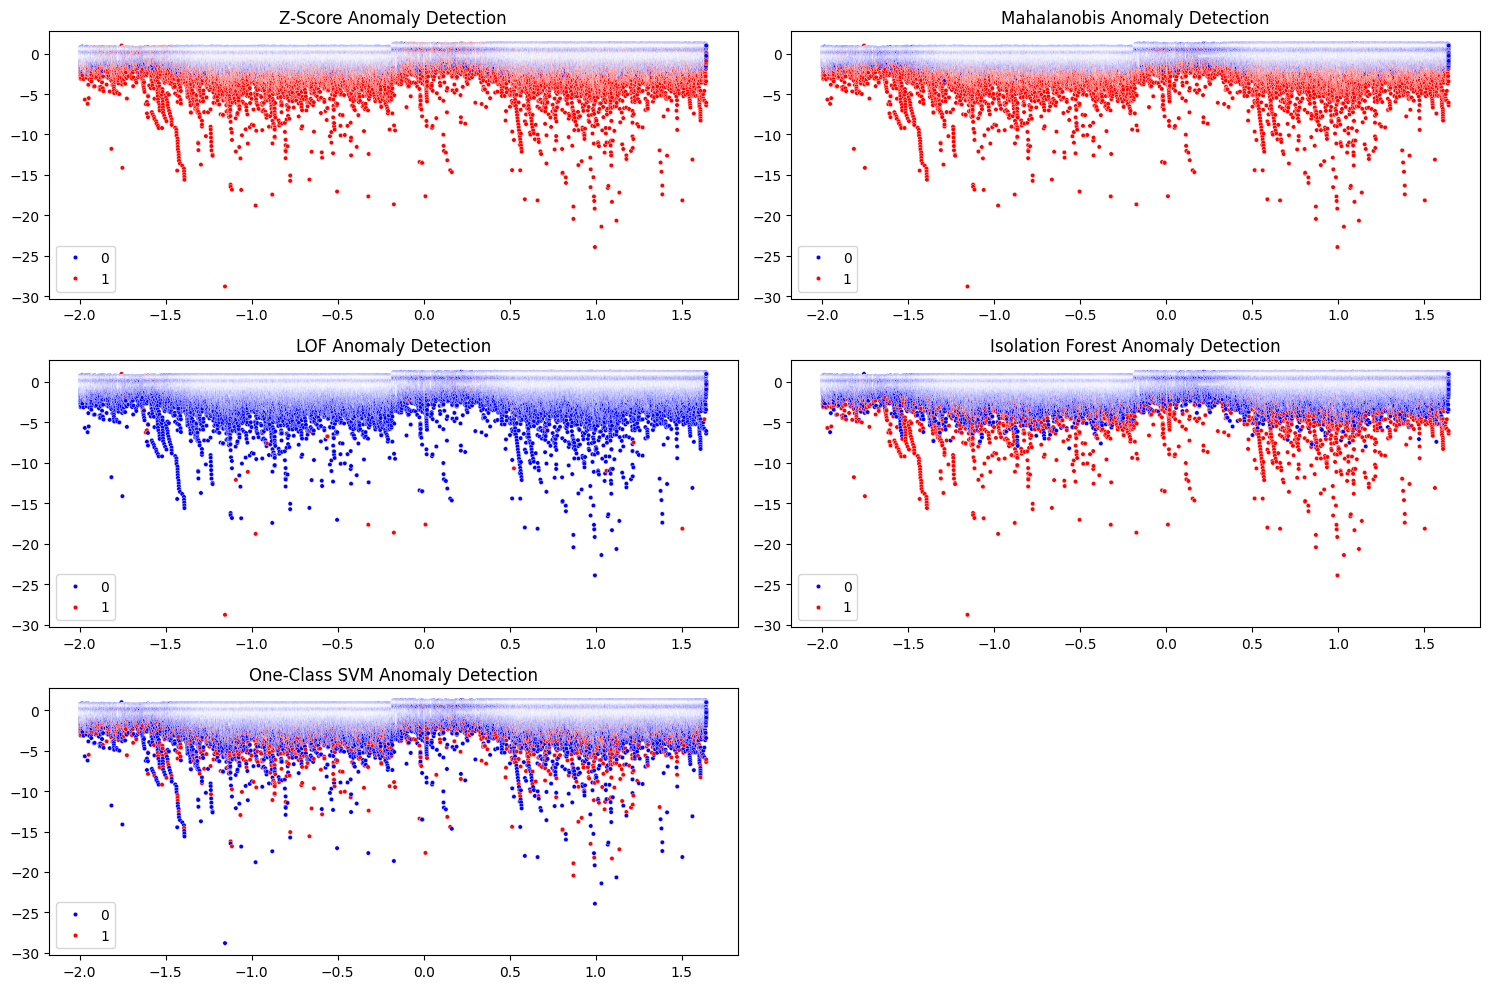

In [12]:

plt.figure(figsize=(15, 10))
for i, (method, preds) in enumerate(zip(methods, predictions)):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=preds, palette={0: 'blue', 1: 'red'}, s=10)
    plt.title(f"{method} Anomaly Detection")
plt.tight_layout()
plt.show()